(array([2.576200e+04, 4.145000e+03, 4.371000e+03, 9.883000e+03,
        7.936025e+06, 2.940162e+06, 3.273823e+06, 2.356497e+06,
        2.250095e+06, 3.035424e+06]),
 array([-9.98985291e-01, -7.99112439e-01, -5.99239588e-01, -3.99366677e-01,
        -1.99493825e-01,  3.79025936e-04,  2.00251937e-01,  4.00124788e-01,
         5.99997640e-01,  7.99870491e-01,  9.99743342e-01]),
 <BarContainer object of 10 artists>)

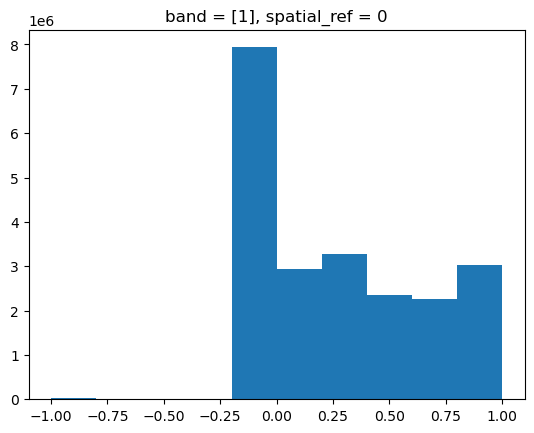

In [8]:
import pystac
import rioxarray
import geopandas
items = pystac.ItemCollection.from_file("data/rhodes_sentinel-2.json")

item = items[0]
rhodes_red_href = item.assets["red"].href  # red band
rhodes_green_href = item.assets["green"].href  # green band
rhodes_blue_href = item.assets["blue"].href  # blue band
rhodes_nir_href = item.assets["nir"].href  # near-infrared band
rhodes_swir16_href = item.assets["swir16"].href  # short-wave infrared (1600 nm) band
rhodes_swir22_href = item.assets["swir22"].href  # short-wave infrared (2200 nm) band
rhodes_visual_href = item.assets["visual"].href  # true-color image

red = rioxarray.open_rasterio("data/sentinel2/red.tif", masked=True)
nir = rioxarray.open_rasterio("data/sentinel2/nir.tif", masked=True)

rhodes = geopandas.read_file('data/rhodes.gpkg')
rhodes_reprojected = rhodes.to_crs(red.rio.crs)
bbox = rhodes_reprojected.total_bounds

# crop the rasters
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)

# red_clip.plot(robust=True)
# nir_clip.plot(robust=True)

# print(red_clip.shape, nir_clip.shape) // Check shape to make sure they match

ndvi = (nir_clip - red_clip)/ (nir_clip + red_clip) 
# print(ndvi) // Normalized difference vegetation index
# ndvi.plot()
# ndvi.plot.hist()





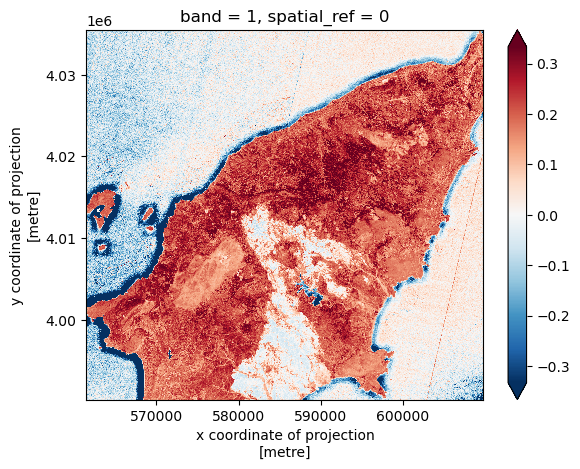

In [14]:
#Exercise 1
green = rioxarray.open_rasterio("data/sentinel2/green.tif", masked=True)
green_clip = green.rio.clip_box(*bbox)
ndwi = (green_clip - nir_clip)/(green_clip + nir_clip)
# print(ndwi)
# ndwi.plot(robust=True)


swir_16 = rioxarray.open_rasterio("data/sentinel2/swir16.tif", masked=True)
swir_22 = rioxarray.open_rasterio("data/sentinel2/swir22.tif", masked=True)
swir16_clip = swir_16.rio.clip_box(*bbox)
swir22_clip = swir_22.rio.clip_box(*bbox)
index = (swir16_clip - swir22_clip)/(swir16_clip + swir22_clip)
# print(index)
# index.plot(robust=True)

#Swir Bands have lower resolutions

In [ ]:
#Adding methods to match instructions
data_path = 'data/sentinel2'
def get_band_and_clip(band_path, bbox):
    band = rioxarray.open_rasterio(band_path, masked=True)
    return band.rio.clip_box(*bbox)

index_match = index.rio.reproject_match(ndvi)
swir16_match = swir16_clip.rio.reproject_match(ndvi)
blue_clip = get_band_and_clip(f'{data_path}/blue.tif', bbox)
burned = (
    (ndvi <= 0.3) &
    (ndwi <= 0.1) &
    ((index_match + nir_clip/10_000) <= 0.1) &
    ((blue_clip/10_000) <= 0.1) &
    ((swir16_match/10_000) >= 0.1)
)
burned = burned.squeeze()
visual = rioxarray.open_rasterio(f'{data_path}/visual.tif')
visual_clip = visual.rio.clip_box(*bbox)
# set red channel to max (255), green and blue channels to min (0).
visual_clip[0] = visual_clip[0].where(~burned, 255)
visual_clip[1:3] = visual_clip[1:3].where(~burned, 0)
visual_clip.plot.imshow()
burned.rio.to_raster('burned.tif', dtype='int8')

